# EDA датасета fetch_lenta для дипломной работы по теме :"Исследование методов отбора признаков в задачах Uplift-моделирования"

**Краткое описание датасета:** Выбранный набор данных представляет собой агрегированную информацию о покупках клиентов сети супермаркетов "Лента", объединенную с данными о проведенных маркетинговых кампаниях. Датасет был подготовлен для решения задачи uplift-моделирования и использовался в открытом конкурсе BigTarget Hackathon.

**Связь с бизнесом:** Супермаркет "Лента" проводил целевые sms-рассылки для увеличения покупок. Бизнес-задача заключается в оптимизации маркетинговых расходов путем ориентации только на тех клиентов, которые увеличат свою активность именно благодаря коммуникационному воздействию, а не совершили бы покупку и без него.

**Описание состава датасета:**

Набор данных содержит 687_029 записей и 193 признаков для моделирования, а так же флаг `treatment`, принимающий значения

*   test - пользователь попал в тестовую выборку, на него было воздействие
*   control - пользователь попал в контрольную группу, воздействия не было.

и колонка `target` - целевая переменная, принимающая значения 0 и 1 -  совершил ли клиент хотя бы одно целевое действие после коммуникации.

In [1]:
!pip install scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [3]:
from sklift.datasets import fetch_lenta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import shap

In [4]:
SEED = 42

### EDA

In [5]:
dataset = fetch_lenta()
data, target, treatment = dataset.data, dataset.target, dataset.treatment

Lenta dataset:   0%|          | 0.00/145M [00:00<?, ?iB/s]

In [6]:
target.shape

(687029,)

In [7]:
treatment.shape

(687029,)

Посмотрим на распределение тритментов

In [8]:
treatment.value_counts(normalize=True)

,proportion
group,
test,0.750903
control,0.249097


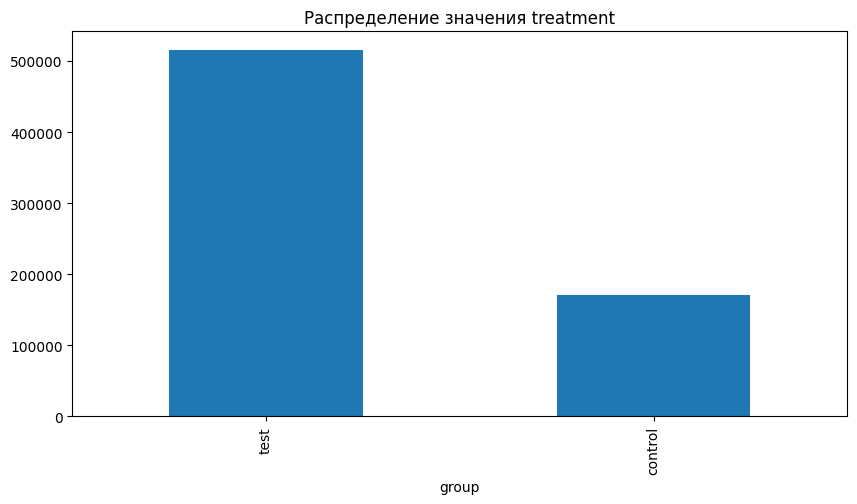

In [9]:
plt.figure(figsize=(10, 5))
treatment.value_counts().plot(kind='bar')
plt.title('Распределение значения treatment')
plt.show()

Теперь посмотрим на распределение таргета

In [10]:
target.value_counts(normalize=True)

,proportion
response_att,
0,0.891754
1,0.108246


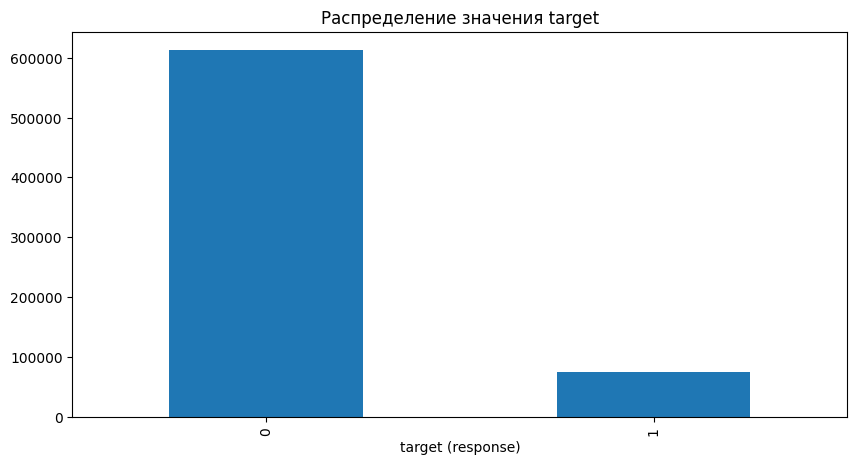

In [11]:
plt.figure(figsize=(10, 5))
target.value_counts().plot(kind='bar')
plt.title('Распределение значения target')
plt.xlabel('target (response)')
plt.show()

Теперь проанализируем признаки:

In [12]:
data.shape

(687029, 193)

In [13]:
data.head()

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,1.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,7.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,1.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,2.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 193 entries, age to stdev_discount_depth_1m
dtypes: float64(191), int64(1), object(1)
memory usage: 1011.6+ MB


In [15]:
print('Типы данных в датафрейме:')
data.dtypes.unique()

Типы данных в датафрейме:


array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

Посмотрим на тип данных объект

In [16]:
data.select_dtypes(include='object').head()

,gender
0,Ж
1,Ж
2,М
3,Ж
4,Ж


In [17]:
print(f'Число пропуском в признаке gender {data["gender"].isna().sum()}')

Число пропуском в признаке gender 8581


Посмотрим на общее число пропусков:

In [18]:
data.isna().sum()

,0
age,11765
cheque_count_12m_g20,0
cheque_count_12m_g21,0
cheque_count_12m_g25,0
cheque_count_12m_g32,0
...,...
sale_sum_6m_g44,3115
sale_sum_6m_g54,3115
stdev_days_between_visits_15d,76954
stdev_discount_depth_15d,140453


Посмотрим на самое минимальное и самое максимальное значения для всех признаков в датасете, чтобы понять, как заполнять пропуски

In [19]:
print(f'Минимальное значение всех признаков в датасете: {data.select_dtypes(exclude='object').min().min()}')
print(f'Максимальное значение всех признаков в датасете: {data.select_dtypes(exclude='object').max().max()}')

Минимальное значение всех признаков в датасете: 0.0
Максимальное значение всех признаков в датасете: 2866854.5


In [20]:
treatment.value_counts(normalize=True)

,proportion
group,
test,0.750903
control,0.249097


Проверим датасет на наличие полных дубликатов

In [21]:
print(f'Число полных дубликатов {data.duplicated().sum()}')

Число полных дубликатов 30


### PSI

Так как при анализе литерутауы было выявлено, что для продакшена uplift моделирования необходимо, чтобы фичи не изменяли своего распределения (ИСТОЧНИК), расчитаем Population Stability Index (PSI) для оценки используемых фичей. Те признаки, PSI которых выше 0.2, исключим из дальнейшего анализа анализа.

In [22]:
# Разделим данные на train и test (данное разделение будем использовать и для дальнейших экспериментов)
data['treatment'] = treatment
data['target'] = target

train_val_idx, test_idx = train_test_split(data.index, test_size=0.2, random_state=SEED, stratify=data[['treatment', 'target']])

train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=SEED, stratify=data.loc[train_val_idx, ['treatment', 'target']])

X_train = data.loc[train_idx]
X_val = data.loc[val_idx]
X_test = data.loc[test_idx]

treatment_train = treatment[train_idx]
treatment_val = treatment[val_idx]
treatment_test = treatment[test_idx]

y_train = target[train_idx]
y_val = target[val_idx]
y_test = target[test_idx]

Теперь посчитаем PSI для всех фичей

In [23]:
def calculate_psi(expected, actual, buckets=10, bucket_type='quantiles'):

    if bucket_type == 'quantiles':
        breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    else:
        breakpoints = np.linspace(expected.min(), expected.max(), buckets + 1)

    breakpoints = np.unique(breakpoints)

    hist_expected, _ = np.histogram(expected, bins=breakpoints)
    hist_actual, _ = np.histogram(actual, bins=breakpoints)

    percent_expected = hist_expected / len(expected)
    percent_actual = hist_actual / len(actual)

    epsilon = 1e-10
    percent_expected = percent_expected + epsilon
    percent_actual = percent_actual + epsilon

    psi_values = (percent_actual - percent_expected) * np.log(percent_actual / percent_expected)
    psi_total = np.sum(psi_values)

    return psi_total, psi_values

In [24]:
def calculate_psi_for_dataframe(df_expected, df_actual, buckets=10, bucket_type='quantiles'):
    results = {}

    numeric_cols = df_expected.drop(columns=['target', 'treatment']).select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in df_actual.columns:
            expected = df_expected[col].dropna()
            actual = df_actual[col].dropna()

            if len(expected) > 0 and len(actual) > 0:
                psi_score, _ = calculate_psi(
                    expected.values,
                    actual.values,
                    buckets=buckets,
                    bucket_type=bucket_type
                )
                results[col] = psi_score

    return pd.Series(results).sort_values(ascending=False)


In [25]:
psi_scores = calculate_psi_for_dataframe(X_train, X_test)

In [26]:
psi_scores

,0
k_var_disc_share_15d_g49,4.513846e-04
k_var_disc_share_1m_g49,3.368569e-04
cheque_count_6m_g40,2.185772e-04
k_var_sku_price_6m_g48,1.668866e-04
k_var_sku_price_1m_g24,1.504240e-04
...,...
k_var_count_per_cheque_1m_g27,1.484045e-06
k_var_disc_share_3m_g46,1.448505e-06
perdelta_days_between_visits_15_30d,2.343666e-07
crazy_purchases_cheque_count_1m,5.306069e-09


Заметим, что самое максимальное значение PSI - 0.00045, что не превышает 0.2, значит оставляем все признаки.

### Тритмент-ассоциированные фичи

Проверим, какие признаки являются "подозрительными" относительно treatment. Построим простой классификатор, которые предсказывает, к какой группе принадлежит клиент: контрольной или тестовой. После чего посмотрим на shap-значения признаков, если какой-то из них имеет слишком большое значение (и следственно сильно влияет на флаг treatment), этот признак потенциально является "тритмент-ассоциированным"

In [27]:
model = CatBoostClassifier(random_seed=SEED, verbose=0)

In [28]:
X_train['gender'] = X_train['gender'].map({'Male': 1, 'Female': 0})
X_val['gender'] = X_val['gender'].map({'Male': 1, 'Female': 0})

In [29]:
model.fit(X_train.drop(columns=['treatment', 'target']), treatment_train)

In [30]:
def get_shap_values(model, X_val):

    X_val_clean = X_val.drop(columns=['treatment', 'target'], errors='ignore')

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_val_clean)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_mean = shap_values.mean(axis=0)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

    res = pd.DataFrame({
        'feature': X_val_clean.columns,
        'shap_mean': shap_mean,
        'shap_abs_mean': shap_abs_mean
    })

    res = res.sort_values('shap_abs_mean', ascending=False)

    res = res.reset_index(drop=True)

    return res


In [31]:
temp = get_shap_values(model, X_val)

In [32]:
temp

,feature,shap_mean,shap_abs_mean
0,response_sms,-0.036733,0.247934
1,response_viber,0.023381,0.151705
2,sale_sum_12m_g44,0.011452,0.019719
3,k_var_cheque_3m,0.002599,0.018381
4,k_var_count_per_cheque_6m_g44,-0.011329,0.017757
...,...,...,...
188,cheque_count_3m_g45,-0.000176,0.001449
189,k_var_disc_share_15d_g24,0.000160,0.001349
190,cheque_count_6m_g57,-0.000176,0.001322
191,cheque_count_3m_g57,-0.000087,0.000555


Можно заметить, что никакие из признаков "не выделяются" по абсолютному значению shap-важности. Значит, никакие из признаков не являются потенцаильно тритмент-ассоциированными.

В качестве доп. анализа посмотрем на распеделение treatment и target на валидации и тесте

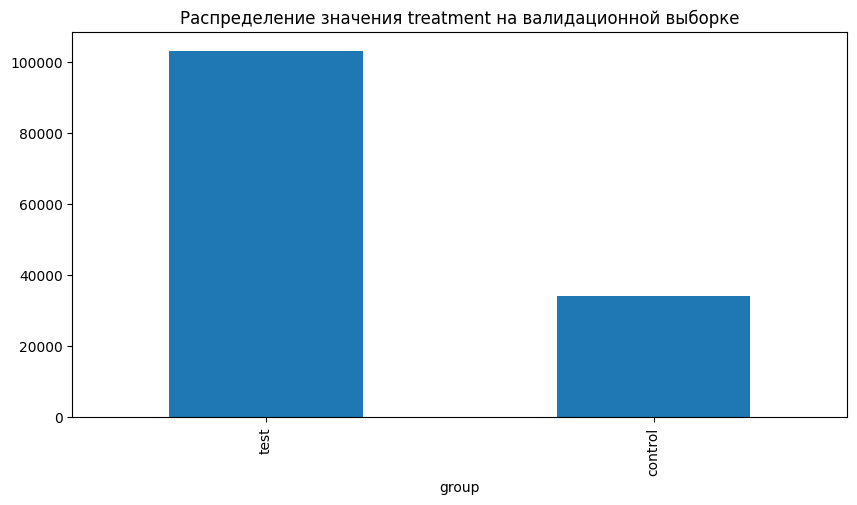

In [33]:
plt.figure(figsize=(10, 5))
treatment_val.value_counts().plot(kind='bar')
plt.title('Распределение значения treatment на валидационной выборке')
plt.show()

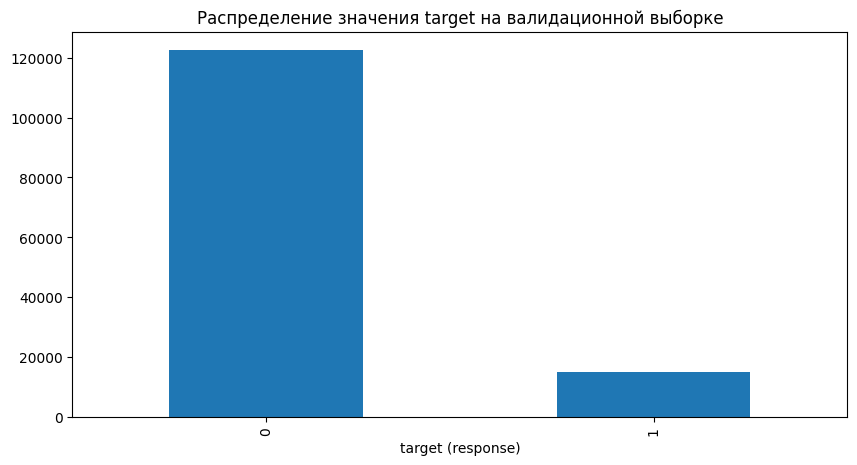

In [34]:
plt.figure(figsize=(10, 5))
y_val.value_counts().plot(kind='bar')
plt.title('Распределение значения target на валидационной выборке')
plt.xlabel('target (response)')
plt.show()

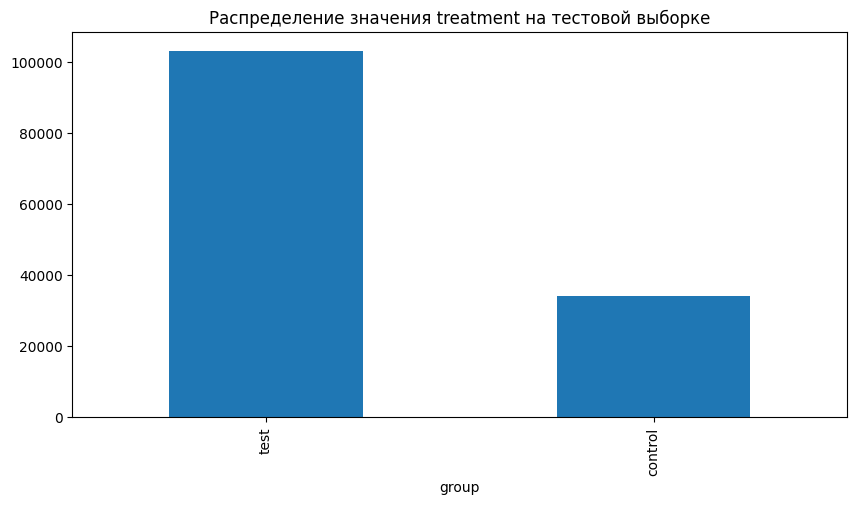

In [35]:
plt.figure(figsize=(10, 5))
treatment_test.value_counts().plot(kind='bar')
plt.title('Распределение значения treatment на тестовой выборке')
plt.show()

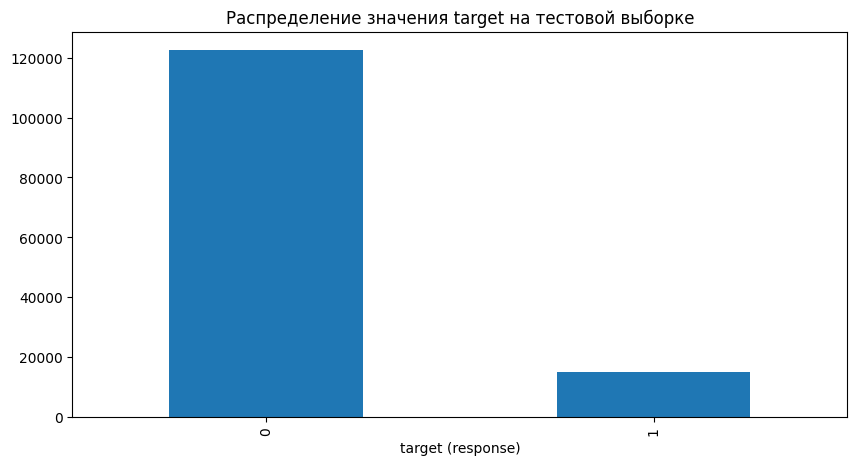

In [36]:
plt.figure(figsize=(10, 5))
y_test.value_counts().plot(kind='bar')
plt.title('Распределение значения target на тестовой выборке')
plt.xlabel('target (response)')
plt.show()

**Вывод**

1) В датасете присутсвует дисбаланс классов: число записей, поповших в тестовую выбоку (воздействие было) составляет 75%, а контрольная группа составляет 25%.

2) Так же в датасете есть дисбаланс таргета: всего лишь 10% покупателей совершили целевое дейсвтие, в то время как другие 90% этого дейсвтия не совершали.

3) В датасете есть пропуски - их нужно заполнить. Так как минимальное значение в датасете - 0, заполним пропсуски значением -100.

4) В датасете есть только один категориальный признак - пол клиента, в данном признаке есть пропуски, их будем заполнять категорией 'unknown'. Для данного признака присвоим значение 1, если пол мужской, 0, если женский.

5) В датасете есть 30 полных дубликатов, от них необходимо избавиться.

6) В результате превичного анализа датаффрейма никакие признаки не были удалены.

Для сравнения последующих экспериментов будем использовать метрику AUUC -